# 迁移学习训练

In [1]:
import tensorflow as tf

In [2]:
# set gpu for training
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

## 1. 定义相关路径和参数

In [3]:
data, train_path, val_path, test_path = '../data/dogVScat/', 'train/', 'val/', 'test/'

In [4]:
size, train_batch_size, val_batch_size = (150, 150), 32, 8

## 2. 加载ResNet50模型

In [5]:
conv_base = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

### 2.1 冻结模型参数

In [6]:
for layers in conv_base.layers[:]:
    layers.trainable = False # 冻结模型参数
x = conv_base.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=conv_base.input, outputs=predictions)

### 2.2 模型的编译

In [7]:
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=tf.keras.metrics.binary_accuracy)

### 2.3 数据生成器

In [8]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator()
train_generator = img_generator.flow_from_directory(
    directory=data+train_path, 
    target_size=size, 
    batch_size=16, 
    class_mode='binary', 
    shuffle=True) # binary 2分类，一维标签
val_generator = img_generator.flow_from_directory(
    directory=data+val_path, 
    target_size=size, 
    batch_size=8, 
    class_mode='binary', 
    shuffle=True
) # binary 2分类，一维标签

Found 20000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


### 2.4 定义回调函数

In [9]:
model_check_point = tf.keras.callbacks.ModelCheckpoint(
    filepath='../models/best_model.h5', 
    monitor='val_binary_accuracy', 
    verbose=1, 
    save_best_only=True, # 仅保存最优模型
    save_weights_only=False, # 是否仅保存权重
    mode='auto' # 设置检测参数的最优方向
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    min_delta=0, # 触发终止的阈值: 最小增量
    patience=10, # 等待训练停止的 无改善时期 的数量
    verbose=1,
    mode='auto'
)

# 设置权重衰减
def scheduler(epoch):
    if epoch % 5 == 0 and epoch != 0:
        lr = tf.keras.backend.get_value(model.optimizer.lr)
        tf.keras.backend.set_value(model.optimizer.lr, lr*0.9)
        print('lr changed to {}'.format(lr*0.9))
    return tf.keras.backend.get_value(model.optimizer.lr)
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

# 保存训练日志
csv_logger = tf.keras.callbacks.CSVLogger('../logs/training.log', separator=',', append=False)
callbacks = [model_check_point, early_stopping, learning_rate_scheduler, csv_logger]

### 2.5 模型的训练

In [10]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      verbose=1,
      validation_data=val_generator,
      validation_steps=8,
      callbacks=callbacks
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.2517 - binary_accuracy: 0.9231
Epoch 00001: val_binary_accuracy improved from -inf to 0.96875, saving model to ../models\best_model.h5
100/100 [==============================] - 17s 170ms/step - loss: 0.2517 - binary_accuracy: 0.9231 - val_loss: 0.0483 - val_binary_accuracy: 0.9688

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.1786 - binary_accuracy: 0.9319
Epoch 00002: val_binary_accuracy did not improve from 0.96875
100/100 [==============================] - 15s 153ms/step - loss: 0.1786 - binary_accuracy: 0.9319 - val_loss: 0.1110 - val_binary_accuracy: 0.9062

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.1287 - binary_accuracy: 0.9519
Epoch 00003: val_bi

## 3. 模型的预测

In [11]:
import os
import numpy as np
import cv2

In [12]:
best_model = tf.keras.models.load_model('../models/best_model.h5')

In [16]:
# 在测试集种随机读取16张图片进行预测
all_test_imgs = os.listdir(data + test_path)
index_img, imgs = np.random.choice(range(len(all_test_imgs)), 16, replace=False), []
for i in index_img:
    img = cv2.imread(data + test_path + all_test_imgs[i])
    img = cv2.resize(img, (150, 150))
    imgs.append(img)
imgs = np.array(imgs)

In [17]:
y_pred = best_model.predict(imgs)
y_pred = [1 if i > 0.5 else 0 for i in y_pred]
y_pred

[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1]

## 4. 预测可视化

In [18]:
import matplotlib.pyplot as plt

In [19]:
label_dict = {0: 'cat', 1: 'dog'}

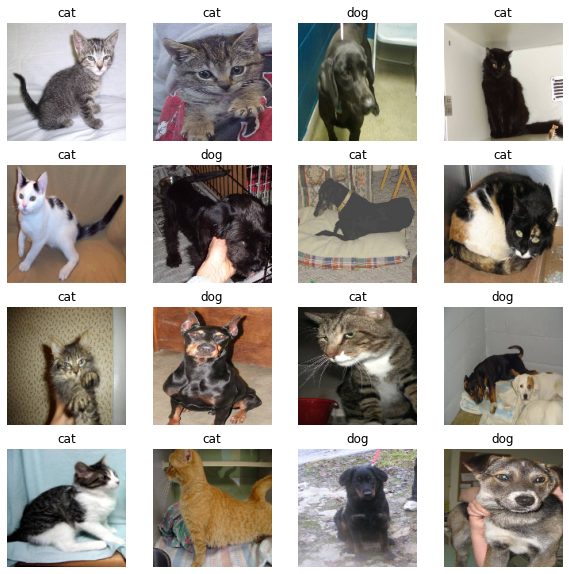

In [21]:
plt.figure(figsize=(10, 10))
for i in range(len(y_pred)):
    ax = plt.subplot(4, 4, i+1)
    ax.set_title(label_dict[y_pred[i]])
    ax.axis('off')
    ax.imshow(imgs[i][:,:,::-1])
plt.show()